<a href="https://colab.research.google.com/github/lesarmiento37/coder-proyecto/blob/main/Copia_de_ProyectoCoderhouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
data = pd.read_csv(r"drive/MyDrive/ProyectoFinalCoder/loan_data_2007_2014.csv", sep=',' ,encoding='latin-1')
data.head(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import seaborn as sns

In [23]:
#Obtener columnas
print(data.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'good_bad'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

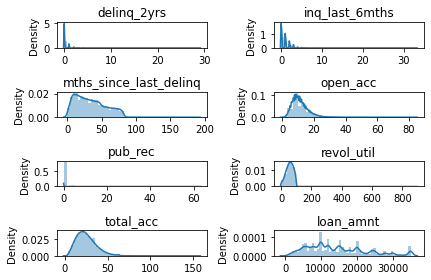

In [46]:
variables = ['delinq_2yrs','inq_last_6mths','mths_since_last_delinq','open_acc','pub_rec','revol_util','total_acc','loan_amnt']

columns = 2

fig, axes = plt.subplots(4,2)

for current_idx, variable in enumerate(variables):
    i = current_idx // columns
    j = current_idx % columns
    sns.distplot(data[variable], ax=axes[i][j])
    axes[i][j].set_title(variable)
    axes[i][j].set_xlabel("")

    
plt.tight_layout()

In [36]:
data_columns = data.columns
df_delinq_2yrs = data['delinq_2yrs']
df_loan_status_counts = data['loan_status'].value_counts()
df_loan_status_counts_normalize = data['loan_status'].value_counts(normalize = True)
#Se determina la variable target "loan-status" si esta en status Charged off, Default, Late o Does not meet the credit policy. Status:Charged Off se considera en mora, de lo contrario clasifica como bueno
print(df_loan_status_counts_normalize)


KeyError: ignored

In [7]:
#Se borran las columnas que tienen mas del 80% de los datos nulos
data.dropna(thresh = data.shape[0]*0.2, how = 'all', axis = 1, inplace = True)
data_columns = data.columns
print(data.head(10))

        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   
5  1075269    1311441       5000         5000           5000.0   36 months   
6  1069639    1304742       7000         7000           7000.0   60 months   
7  1072053    1288686       3000         3000           3000.0   36 months   
8  1071795    1306957       5600         5600           5600.0   60 months   
9  1071570    1306721       5375         5375           5350.0   60 months   

   int_rate  installment grade sub_grade  ... next_pymnt_d last_credit_pull_d  \
0     10.65       162.87     B        B2  ...          NaN  

In [8]:
#Se borran las columnas redundantes
#data.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title', 'zip_code', 'next_pymnt_d', 'recoveries', 'collection_recovery_fee','total_rec_prncp', 'total_rec_late_fee'], inplace = True)
print(data.head(10))

        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   
5  1075269    1311441       5000         5000           5000.0   36 months   
6  1069639    1304742       7000         7000           7000.0   60 months   
7  1072053    1288686       3000         3000           3000.0   36 months   
8  1071795    1306957       5600         5600           5600.0   60 months   
9  1071570    1306721       5375         5375           5350.0   60 months   

   int_rate  installment grade sub_grade  ... next_pymnt_d last_credit_pull_d  \
0     10.65       162.87     B        B2  ...          NaN  

In [9]:
#Explorar los valores unicos en la columna loan_status
print(data['loan_status'].value_counts(normalize = True))

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64


In [10]:
#Crear una nueva columna basada en el loan_status que será nuestra variable target
data['good_bad'] = np.where(data.loc[:,'loan_status'].isin(['Charged Off', 'Default','Late (31-120 days)','Does not meet the credit policy. Status:Charged Off']),0, 1)
print(data['good_bad'].head(10))
print(data['loan_status'].head(10))

0    1
1    0
2    1
3    1
4    1
5    1
6    1
7    1
8    0
9    0
Name: good_bad, dtype: int64
0     Fully Paid
1    Charged Off
2     Fully Paid
3     Fully Paid
4        Current
5     Fully Paid
6        Current
7     Fully Paid
8    Charged Off
9    Charged Off
Name: loan_status, dtype: object


In [11]:
#Eliminando la columna original de loan_status y reemplazandola por good_bad
data.drop(columns = ['loan_status'], inplace = True)
print(data.head(10))

        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   
5  1075269    1311441       5000         5000           5000.0   36 months   
6  1069639    1304742       7000         7000           7000.0   60 months   
7  1072053    1288686       3000         3000           3000.0   36 months   
8  1071795    1306957       5600         5600           5600.0   60 months   
9  1071570    1306721       5375         5375           5350.0   60 months   

   int_rate  installment grade sub_grade  ... last_credit_pull_d  \
0     10.65       162.87     B        B2  ...             Jan-16   
1    

In [12]:
#Para mantener el modelo se realiza un split de los datos de 80 20 mientras se mantiene la distribución de malos prestamos en el conjunto de prueba en el pre-split dataset
X = data.drop('good_bad', axis = 1)
y = data['good_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
#Se realiza una copia de los dataset obtenidos
X_train, X_test = X_train.copy(), X_test.copy()

In [13]:
#Metodos de limpieza de datos
# function to clean up the emp_length column, assign 0 to NANs, and convert to numeric
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)

#function to convert date columns to datetime format and
#reate a new column as a difference between today and the respective date

def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2020-08-01')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)
# function to remove 'months' string from the 'term' column and convert it to numeric
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

In [14]:
#Aplicar metodos al dataset x train
date_columns(X_train, 'earliest_cr_line')
date_columns(X_train, 'issue_d')
date_columns(X_train, 'last_pymnt_d')
date_columns(X_train, 'last_credit_pull_d')
emp_length_converter(X_train, 'emp_length')
loan_term_converter(X_train, 'term')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [15]:
X_train['mths_since_earliest_cr_line'].head(10)

456615    296.0
451541    301.0
394474    359.0
110294    224.0
139343    494.0
258763    157.0
320709    229.0
462741    207.0
347988    473.0
72091     286.0
Name: mths_since_earliest_cr_line, dtype: float64

In [16]:
#Primero se divide la data training en subconjuntos categoricos y numéricos
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()
#Se define un diccionario vacío para guardar los valores de test chi-squared 
chi2_check = {}

In [17]:
#Se realiza un loop a través de cada columna en el training set para calcular los valores estadísticos de chi con la variable target
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

In [18]:
#Se convierte el diccionario a un DataFrame
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)

In [19]:
#Debido a que la distribución f no permite valores nulos, realizaremos un reemplazo de estos
X_train_num.fillna(X_train_num.mean(), inplace = True)
#Se calculan las estadísticas F
F_statistic, p_values = f_classif(X_train_num, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [31] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [20]:
#Se convierten a DataFrame
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values,'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
#Se guardan los 20 valores con mayor valor en F y se almacenan en una lista
top_num_features = ANOVA_F_table.iloc[:20,0].to_list()

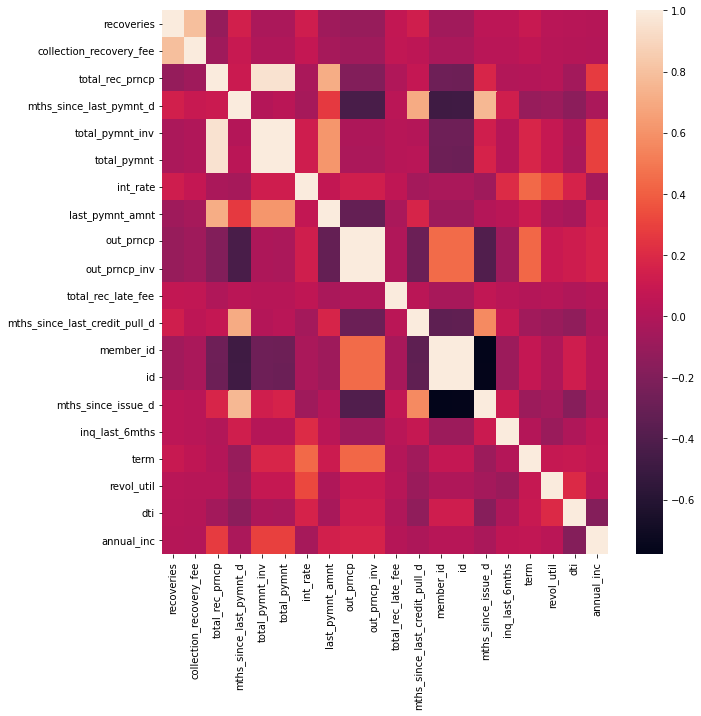

In [21]:
#Se calculan las correlaciones entre ellos
import seaborn as sns
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat)


In [22]:
#Se guardan los nombres de las columnas que serán eliminadas en una lista
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv'])
#Se añade la función para eliminar estas columnas
def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)
#Se aplican los cambios a X_train
col_to_drop(X_train, drop_columns_list)